In [1]:
import numpy as np
import torchaudio
import librosa
import librosa.display

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F

from torchvision.utils import make_grid 
import matplotlib.pyplot as plt    
import os
import random
from tqdm import tqdm 

In [2]:
crema_d_spec_path = './AudioWAV/1001_DFA_ANG_XX.wav'

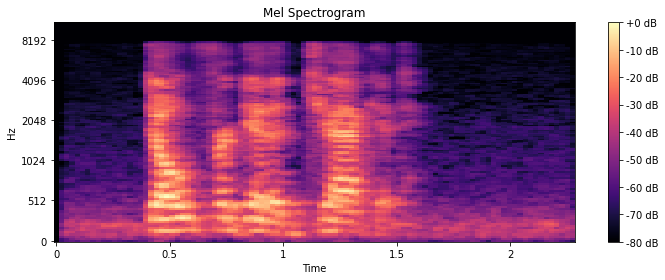

In [3]:
y, sr = librosa.load(crema_d_spec_path)

# Compute the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibel scale (log scale)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [6]:
waveform, sample_rate = torchaudio.load(crema_d_spec_path)
print(waveform, sample_rate)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.1035e-05, 0.0000e+00,
         0.0000e+00]]) 16000


In [9]:
def load_dataset(directory):
    dataset = []
    emotion_to_number = {'NEU': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'DIS': 4, 'FEA': 5}
    max_len = 0
    
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            emotion = filename.split('_')[2]
            emotion_no = emotion_to_number[emotion]
            emotion_label = torch.zeros(6)
            emotion_label[emotion_no] = 1
            
            # Load audio waveform
            waveform, _ = torchaudio.load(filepath)
            
            # Compute spectrogram
            mel_spec_transform = torchaudio.transforms.MelSpectrogram()
            spectrogram = mel_spec_transform(waveform)
            
            max_len = max(max_len, waveform.size(1))  # Update max length
            
            dataset.append((waveform, spectrogram, emotion_label))

    # Pad waveforms to max length
    dataset = [(torch.nn.functional.pad(waveform, (0, max_len - waveform.size(1))), spectrogram, label)
               for waveform, spectrogram, label in dataset]

    return dataset

def split_dataset(dataset, batch_size, train_ratio=0.8):

    # Split dataset into training and testing sets
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader objects for training and testing sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

In [10]:
crema_d_path = './AudioWAV'
dataset = load_dataset(crema_d_path)
train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, 32)

/opt/anaconda3/lib/python3.7/site-packages/torchaudio/functional/functional.py:572: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
